In [2]:
suppressPackageStartupMessages({
    library(scater)
    library(scran)
    library(tidyverse)
    library(ComplexHeatmap)
    library(circlize)
    library(logger)
    
})

# Read Data

In [3]:
intSiteHBV <- readr::read_tsv("./data/HBV_intSites.tsv", guess_max = 1000, col_types = cols(siteHuman = col_character(),
                                                                                            representSites = col_character()))
sce <- readRDS("../../data/expression/sce/sce_Smartseq2_scHCC-CD45_featureCounts_qc_clustered_analysed.rds")

In [19]:
sub <- sce[, grepl("^HCC|Hepa_C01", sce$celltype)]

In [20]:
table(sub$celltype, sub$subsets_HBV_sum > 0)

                        
                         FALSE TRUE
  HCC_D20170322             11   15
  HCC_D20170327            163    4
  HCC_D20170412              0   16
  HCC_D20171109              5   10
  HCC_D20171220             12  146
  HCC_D20180108             20    1
  HCC_D20180110            244   23
  Hepa_C01-AdjacentLiver    36    5

In [21]:
colSums(table(sub$celltype, sub$subsets_HBV_sum > 0))

FALSE  TRUE 
  491   220

In [23]:
491+220

[1] 711

In [22]:
220/(491+220)

[1] 0.3094233

## Meta data

In [24]:
metadata <- intSiteHBV %>% distinct(cell.id, donor, tissue) %>% as.data.frame()
rownames(metadata) <- metadata$cell.id
metadata$cell.id <- NULL

In [28]:
sub

class: SingleCellExperiment 
dim: 60682 711 
metadata(4): pca neighbors umap leiden
assays(2): logcounts counts
rownames(60682): DDX11L1 WASH7P_ENSG00000227232 ... HPV-mRTRX7 HPV-mSD2
rowData names(10): Geneid Chr ... highly_variable varm
colnames(711): TP5-100-0322 TP5-108-0322 ... TP5-9-20180110
  TP5-95-20180110
colData names(39): cell.id cell.type ... UMAP1.ENDO UMAP2.ENDO
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):

In [41]:
table(intSiteHBV$leiden_global_celltype)


Endothelial Cell      Hepatocytes 
               6              110 

In [30]:
aa <- makePerCellDF(sce[,rownames(metadata)])

In [42]:
intSiteHBV %>% filter(leiden_global_celltype != 'Endothelial Cell') %>% 
group_by(cell.id) %>% summarise(count = n()) %>% group_by(count) %>% summarise(n()) 

count,n()
<int>,<int>
1,104
2,3


In [43]:
104/107

[1] 0.9719626

In [35]:
table(aa$celltype, aa$tissue)

                        
                         Normal Tumor
  Endo_C02-CD200              0     2
  HCC_D20170322               0     9
  HCC_D20170327               0     1
  HCC_D20170412               0     1
  HCC_D20171109               0     4
  HCC_D20171220               0    90
  HCC_D20180108               1     0
  Hepa_C01-AdjacentLiver      1     0

# Oncoplot

## Prepare oncomatrix

In [20]:
intSiteCount <- intSiteHBV %>% 
  dplyr::group_by(representSites, cell.id) %>% 
  summarise(count = n()) %>%
  tidyr::spread(key =cell.id, value = count, fill = 0)

mt <- as.matrix(intSiteCount[, 2:ncol(intSiteCount)])
sites <- intSiteCount[[1]]
#siteGene <- intSiteCount[[2]]
rownames(mt) <-  sites




`summarise()` has grouped output by 'representSites'. You can override using the `.groups` argument.



## Assign cell alteration

In [21]:
site2region <- c('1:36463850'   = "Intragenic Splice-site",
  '12:111792137' = "Intragenic Exon",
  '16:35980665'  = "Intergenic", 
  '17:45723492'  = "Intergenic", 
  "18:32284721"  = "Intragenic Intron", 
  "18:56852377"  = "Intragenic Intron", 
  "18:57027004"  = "Intragenic Splice-site", 
  '20:372498'    = 'Intragenic Intron',
  '21:8415795'   = 'Intergenic',
  '22:10749818'  = 'Intergenic',
  '3:156523895'  = 'Intergenic',
  '5:1262800'    = 'Intragenic Intron',
  '5:1292029'    = 'Intragenic Intron',
  '9:26713423'   = 'Intergenic'
)

In [22]:
for( site in names(site2region) ) {
    mt[site,][mt[site,] == 1] = paste0(site2region[site]) 
}
mt[which(mt == 0)] <- ''


In [23]:
col = ggsci::pal_npg()(4)
names(col) <- c("Intergenic", "Intragenic Intron", "Intragenic Splice-site",  "Intragenic Exon")

In [24]:
alter_fun = list(
     background = alter_graphic("rect", col = 'white', fill = "#00FF0020"),   
    Intergenic = alter_graphic('rect', width = 1.05, height = 1, fill = col['Intergenic']),
   `Intragenic Intron` = alter_graphic('rect', width = 1.05, height = 1, fill = col["Intragenic Intron"]),
    `Intragenic Splice-site` =  alter_graphic('rect', width = 1.05, height = 1, fill = col["Intragenic Splice-site"]),
    `Intragenic Exon` =  alter_graphic('rect', width = 1.05, height = 1, fill = col["Intragenic Exon"]))

In [25]:
#--- cell info

mt <- mt[, order(metadata$donor, metadata$tissue)]
meta <- metadata[colnames(mt), c("donor", "tissue")]
rownames(mt) <- paste0("chr", rownames(mt))

In [26]:
set.seed(319)
pal <- ggsci::pal_futurama()(10)
cols_donors <- colorRampPalette(pal)(length(unique(sce$donor)))
cols_donors <- sample(cols_donors)
names(cols_donors) <- unique(sce$donor)

In [27]:
cols_tissue <- ggsci::pal_jco()(2)
names(cols_tissue) <- c("Tumor","Normal")

In [28]:
rownames(mt) <- paste0( c("(MRPS15) ", "(ALDH2) ", "", "","(GAREM) ", "(WDR7) ",  "(WDR7) ", "(TRIB3) ", "", "", "", "(TERT) ", "(TERT) ", ""),
                       rownames(mt))

In [29]:
ha <- HeatmapAnnotation(df = meta, col = list(donor = cols_donors, tissue = cols_tissue),   annotation_label = c("Donor", "Tissue"),
                        border = T, annotation_name_side = 'left')

All mutation types: Intergenic, Intragenic Intron, Intragenic
Splice-site, Intragenic Exon.

`alter_fun` is assumed vectorizable. If it does not generate correct
plot, please set `alter_fun_is_vectorized = FALSE` in `oncoPrint()`.



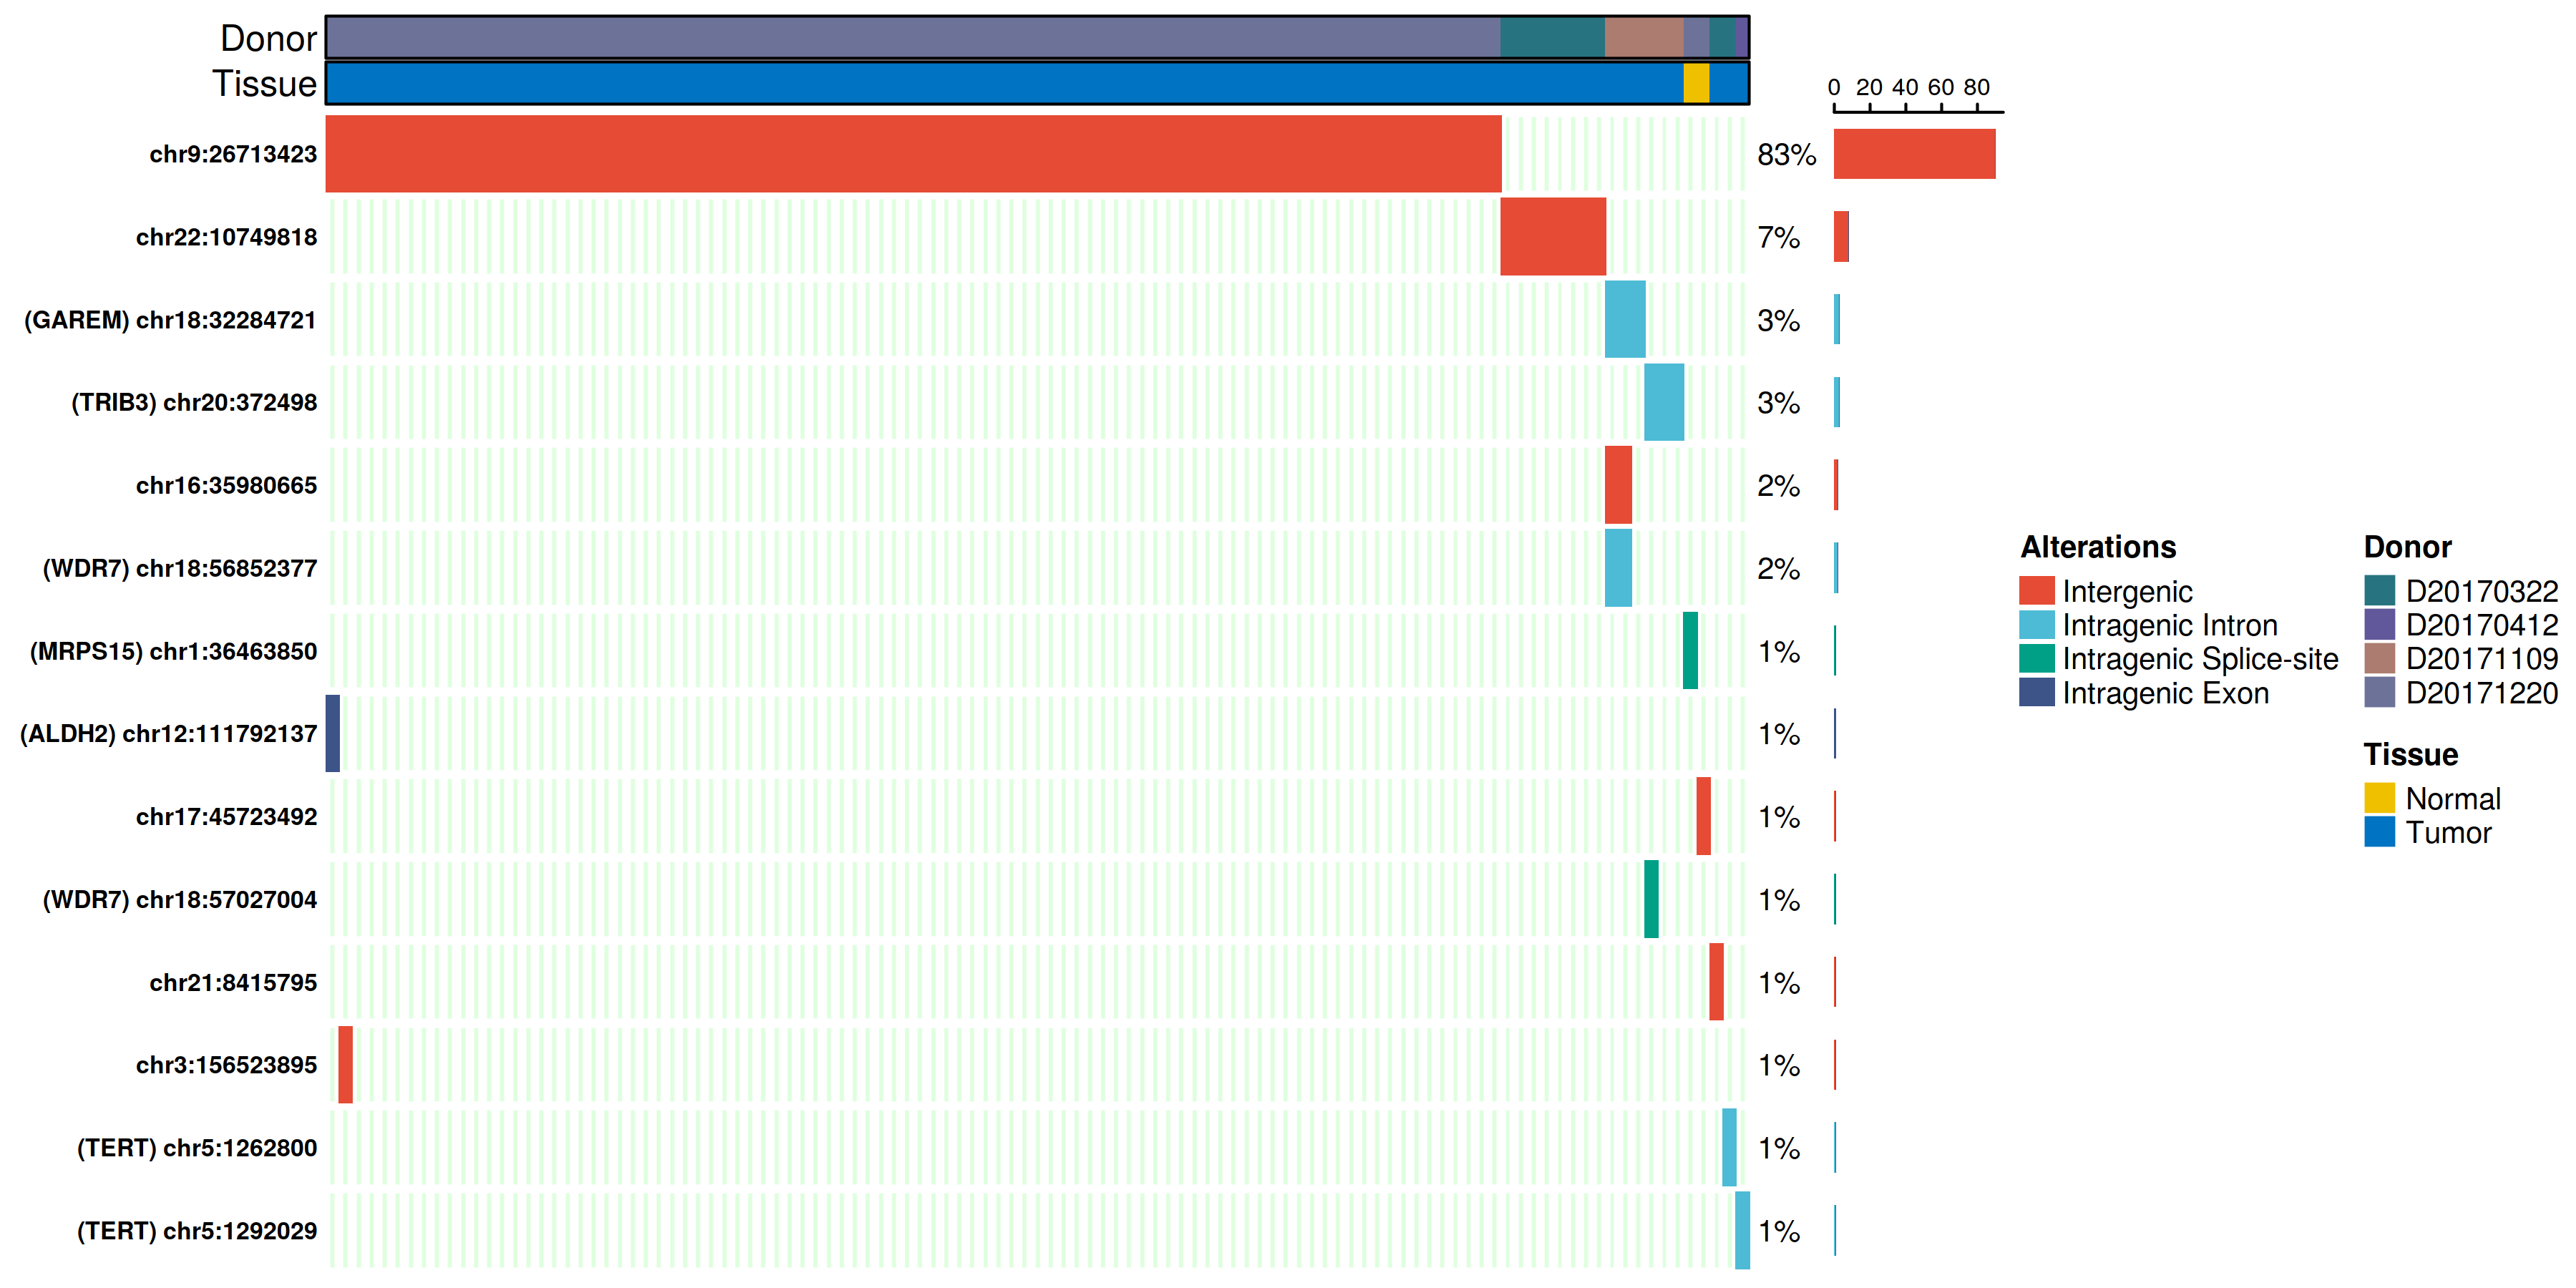

In [30]:
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)
ComplexHeatmap::oncoPrint(mt, alter_fun = alter_fun, col = col, remove_empty_columns = T, remove_empty_rows = T, row_names_side = "left", 
                          pct_side = 'right', top_annotation = ha,  row_names_gp = gpar(fontsize = 8, fontface = 'bold' ))

In [249]:
pdf("../05_figures/figures/Figure2D_Heatmap_HBVintegration_Pattern.pdf", width = 10, height = 4)
options(repr.plot.width = 12, repr.plot.height = 6, repr.plot.res = 300)
ComplexHeatmap::oncoPrint(mt, alter_fun = alter_fun, col = col, remove_empty_columns = T, remove_empty_rows = T, row_names_side = "left", 
                          pct_side = 'right', top_annotation = ha,  row_names_gp = gpar(fontsize = 8, fontface = 'bold' ))
dev.off()

All mutation types: Intergenic, Intragenic Intron, Intragenic
Splice-site, Intragenic Exon



png 
  2

# Circlize plot

## Prepare chromsome 

In [31]:
cytoband <- read.cytoband()$df
cytoband <- rbind(cytoband, data.frame(V1 = 'HBV', V2 = 0, V3 = 3182, V4 = "", V5 = ""))
cytoband <- cytoband[!(cytoband$V1 %in% c("chrX", "chrY")),]
xrange = tapply(cytoband[[3]], cytoband[[1]], max) - tapply(cytoband[[2]], cytoband[[1]], min) 
normal_sector_index = c(paste0("chr", 1:22))
zoomed_sector_index =  "HBV"
sector.width = c(xrange[normal_sector_index] / sum(xrange[normal_sector_index]), 
                 0.3)
sector.width

chr1       chr2       chr3       chr4       chr5       chr6       chr7 
0.08651431 0.08441394 0.06873313 0.06634921 0.06279527 0.05939364 0.05523666 
      chr8       chr9      chr10      chr11      chr12      chr13      chr14 
0.05080261 0.04901486 0.04704380 0.04686045 0.04645968 0.03997520 0.03726078 
     chr15      chr16      chr17      chr18      chr19      chr20      chr21 
0.03558841 0.03136193 0.02818267 0.02710043 0.02052353 0.02187601 0.01670578 
     chr22            
0.01780770 0.30000000

## Prepare HBV genes

In [32]:


gene_hbv <- tribble(~chr, ~start, ~end, ~gene,
       "HBV", 1376, 1840, "X",
       "HBV", 1816, 2454, "C")
gene_hbv <- as.data.frame(gene_hbv)
#gene_hbv$type <- 'cds'

## For link

In [37]:
cols <- wesanderson::wes_palettes$GrandBudapest1[1:2]
df <- intSiteHBV[, c("chrHuman", "coordHuman", "coordHuman", "chrVir", "coordVir", "coordVir", "representSites", "donor", "tissue")]
col_donor <- ggsci::pal_npg(palette = "nrc")(length(unique(df$donor) ))
names(col_donor) <- unique(df$donor)

df$col_links <- plyr::mapvalues(df$donor, from = names(col_donor), to = col_donor)
col_chr <- colorRampPalette(ggthemes::tableau_color_pal("Tableau 20")(20))(23)
names(col_chr) <- unique(cytoband$V1)

## Plot function

In [42]:
head(df)

chrHuman,coordHuman,coordHuman,chrVir,coordVir,coordVir,representSites,donor,tissue,col_links
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
9,26713423,26713423,HBV,1800,1800,9:26713423,D20171220,Tumor,#E64B35FF
9,26713422,26713422,HBV,1670,1670,9:26713423,D20171220,Tumor,#E64B35FF
9,26711904,26711904,HBV,458,458,9:26713423,D20171220,Tumor,#E64B35FF
9,26713418,26713418,HBV,1800,1800,9:26713423,D20171220,Tumor,#E64B35FF
9,26713406,26713406,HBV,1767,1767,9:26713423,D20171220,Tumor,#E64B35FF
9,26713414,26713414,HBV,1800,1800,9:26713423,D20171220,Tumor,#E64B35FF


In [38]:
circle_plot <- function() {
    n = nrow(gene_hbv)
#circos.par(start.degree = 90, points.overflow.warning = FALSE)
    circos.initializeWithIdeogram(cytoband, sector.width = sector.width, track.height = .01,  plotType = c("axis"),)
    circos.track(ylim = c(0,1), panel.fun = function(x, y) {
        chr = CELL_META$sector.index
        xlim = CELL_META$xlim
        ylim = CELL_META$ylim
        circos.rect(xlim[1], 0, xlim[2], 1, col = col_chr[CELL_META$sector.index], border = NA)
        circos.text(mean(xlim), mean(ylim), chr, cex = 0.7, col = "white",
        facing = "inside", niceFacing = TRUE)
    }, track.height = 0.05, bg.border = NA)



    circos.genomicTrack(gene_hbv, ylim = c(0.01, .05),track.height = 0.05, 
                        panel.fun = function(region, value, ...) {
                            all_tx = unique(value$gene)
                            for(i in seq_along(all_tx)) {
                                l = value$gene == all_tx[i]
                                current_tx_start = min(region[l, 1])
                                current_tx_end = max(region[l, 2])
                                circos.genomicRect(region[l,,drop = F], ybottom = (n - i)/100 + 0.02, ytop = (n - i)/100 + 0.03,
                                               col = cols[i], border = NA)
                            }
                        },  bg.border = NA )   
    circos.genomicLink(df[, 1:3], df[, 4:6], col = df$col_links, border = NA)
    circos.clear()
}

In [39]:
lgd_lines = Legend(at = names(col_donor), 
                   type = "lines", 
                   legend_gp = gpar(col = col_donor, lwd = 2), title_position = "topleft", 
                   title = "Links")

In [328]:
options(repr.plot.width = 8, repr.plot.height = 9, repr.plot.res = 300)
pdf("./test.pdf", height = 9, width = 8)
library(gridBase)
plot.new()
circle_size = unit(1, "snpc") # snpc unit gives you a square region
pushViewport(viewport(x = 0.5, y = 1, width = circle_size, height = circle_size,
    just = c("center", "top")))
par(omi = gridOMI(), new = TRUE)
circle_plot()
upViewport()
draw(lgd_lines,  y = unit(1, "snpc") - unit(0.85, 'snpc'), just = "top")
dev.off()

png 
  2

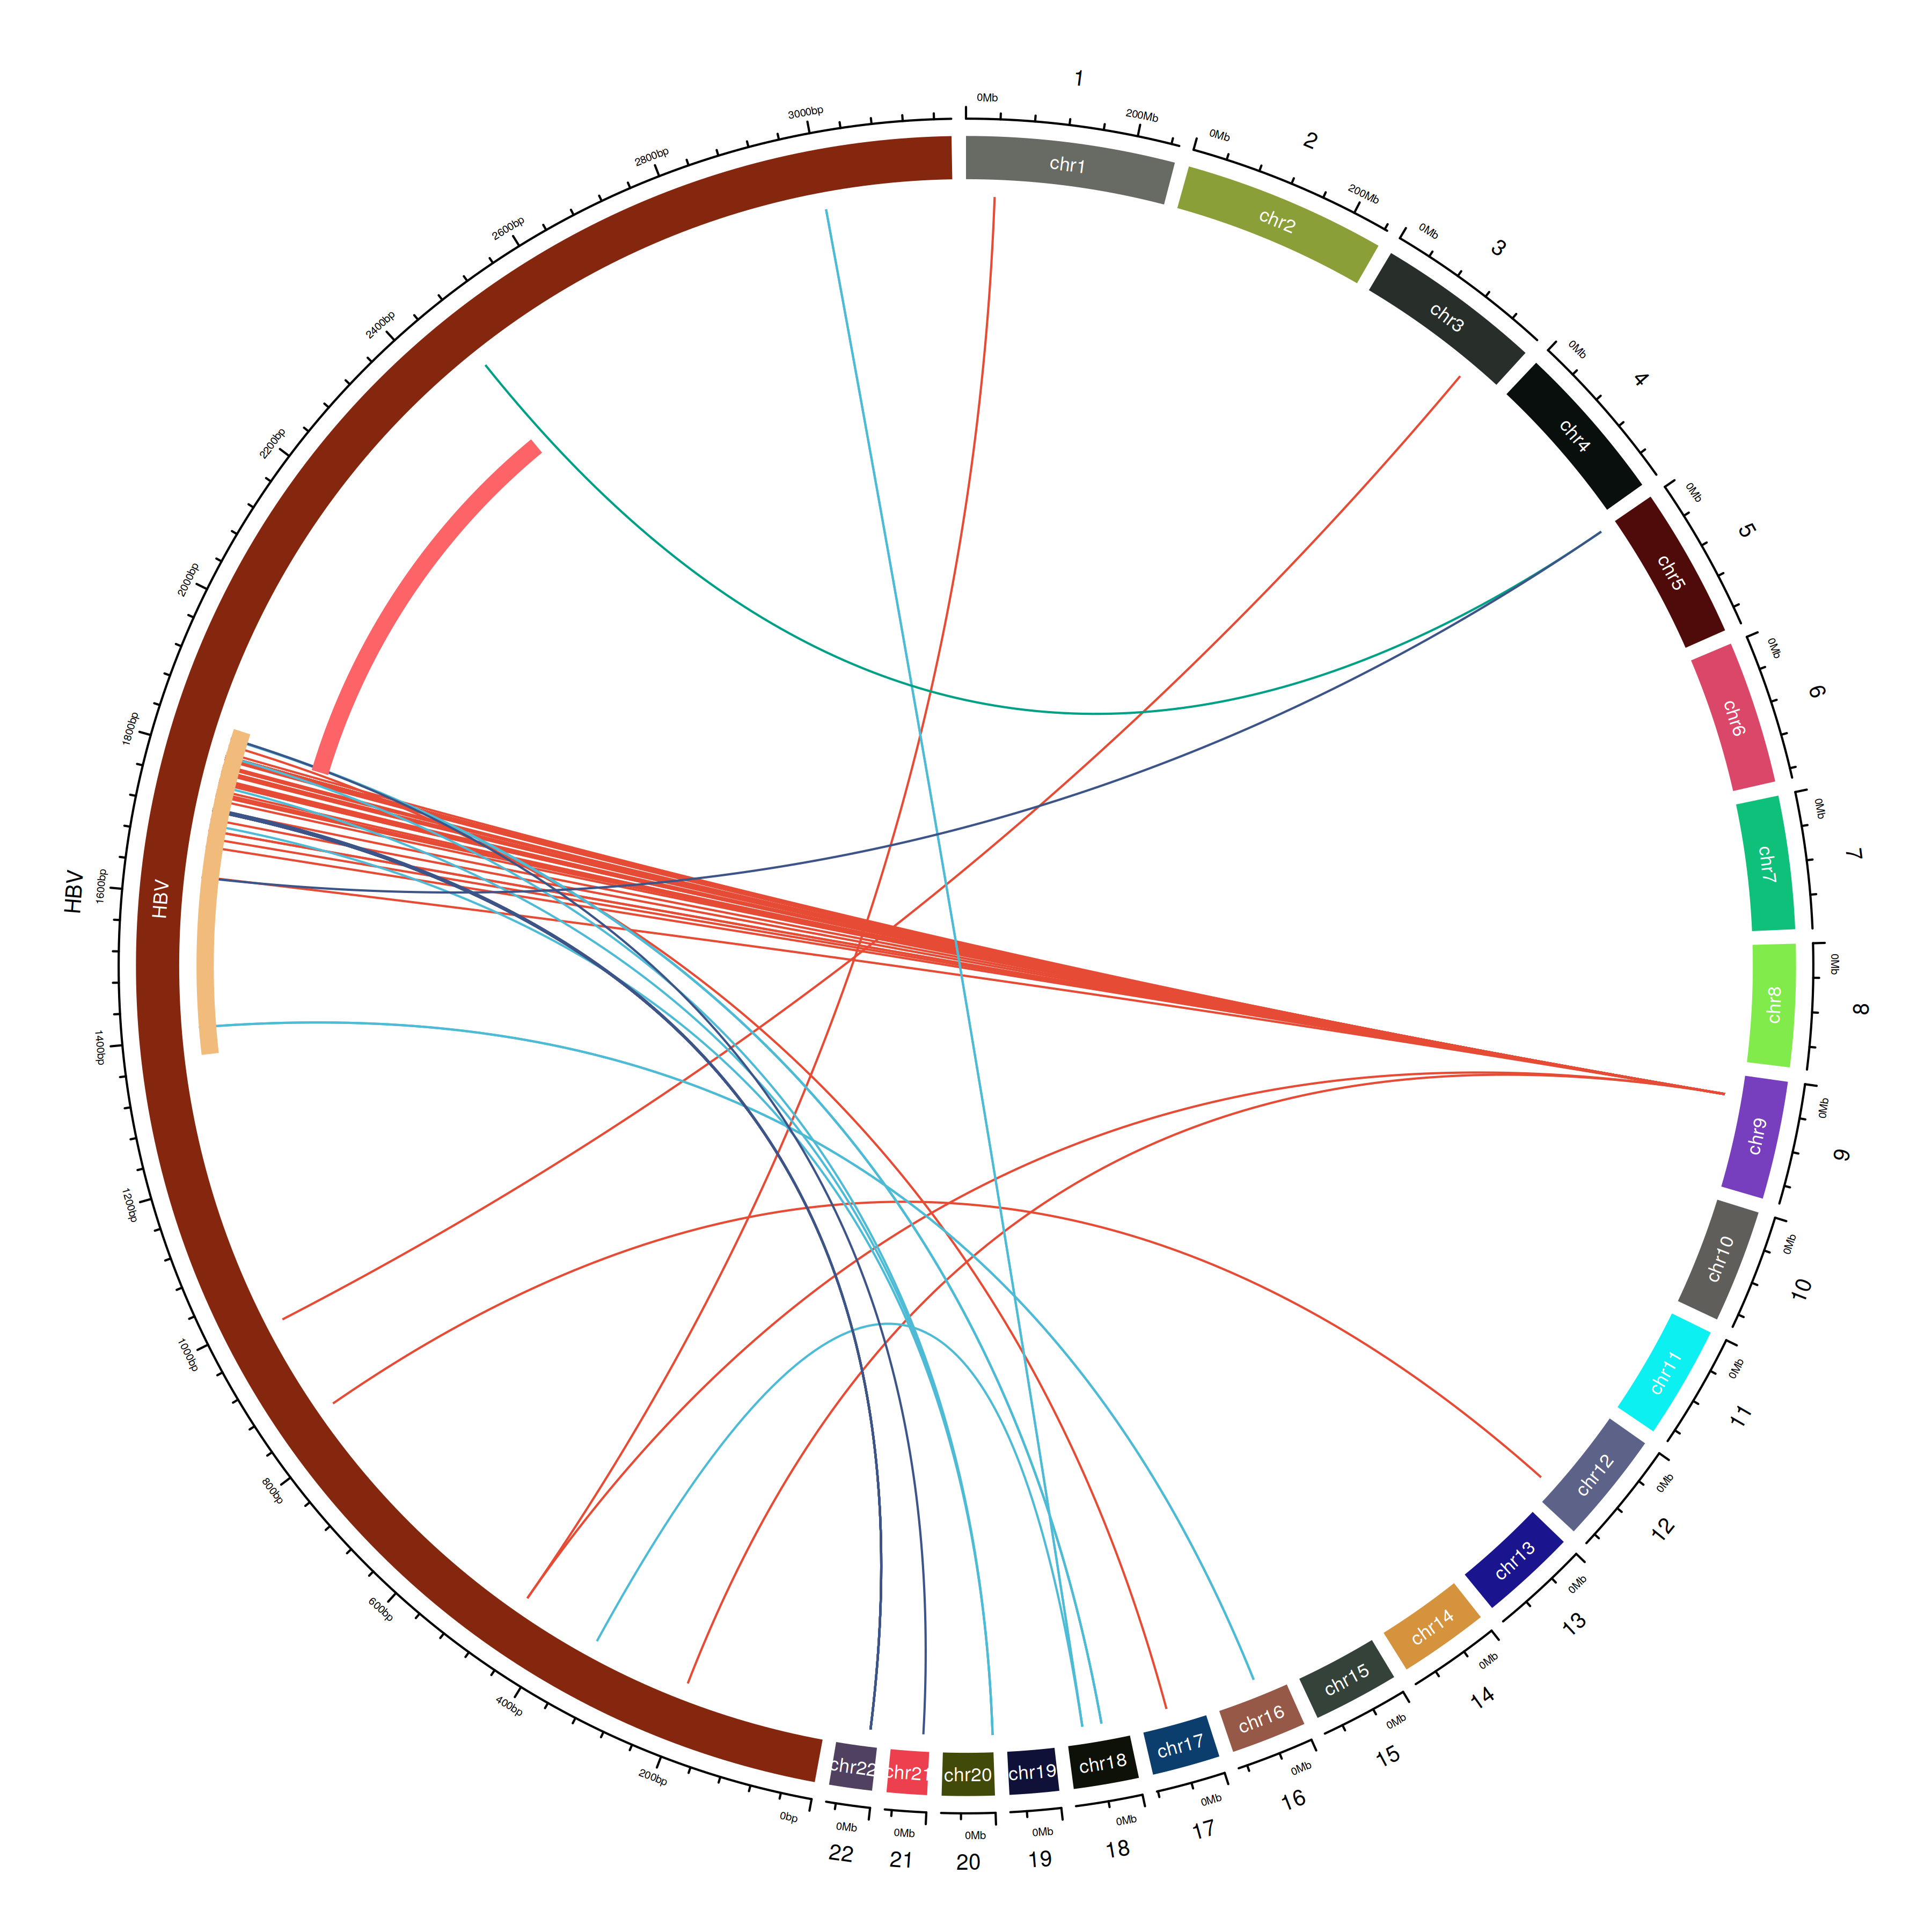

In [249]:
options(repr.plot.width = 1, repr.plot.height = 12, repr.plot.res = 300)


#circos.genomicIdeogram(cytoband)


In [19]:
#--- Get Genome Length
chr.used <- paste0("chr", unique(intSiteHBV$chrHuman))
chr.length <- cbind(chr = chr.used, as.data.frame(seqlengths(BSgenome.Hsapiens.UCSC.hg38))[chr.used,, drop = F])
names(chr.length) <- c("chr", "length")
intSiteHBV$chrHuman <- paste0("chr", as.character(intSiteHBV$chrHuman))

In [20]:
#--- Add chromosome length
intSitePlot <- intSiteHBV %>% 
    left_join(chr.length, by = c("chrHuman" = "chr")) %>%
    mutate(coordHuman_norm = coordHuman / length,
           coordVir_norm = (coordVir/3297) * 6) 

In [105]:
pdf("../05_figures/figures/Figure2C_Circle_plot_HBVintegration_site.pdf", width = 6, height = 6)
circos.par("track.height" = 0.1)
circos.initialize(c(paste0("chr", c(1:22)), "HBV"), xlim = matrix(data = c(rep(c(0,1), 22), c(0,6)), byrow = T, nrow = 23, ncol = 2) )
circos.track(ylim = c(0, 1), track.height = 0.05)
for (i in 1:nrow(intSitePlot)) {
    circos.link(sector.index1 = intSitePlot$chrHuman[i], point1 = intSitePlot$coordHuman_norm[i], sector.index2 = "HBV", point2 = intSitePlot$coordVir_norm[i], directional =  1)
}
circos.clear()
dev.off()

png 
  2

# Virus site plot

In [52]:
table(intSiteHBV$representSites)


  1:36463850 12:111792137  16:35980665  17:45723492  18:32284721  18:56852377 
           1            1            2            1            3            2 
 18:57027004    20:372498   21:8415795  22:10749818  3:156523895    5:1262800 
           1            3            1            8            1            1 
   5:1292029   9:26713423 
           1           90 

In [39]:
theme_bw

function (base_size = 11, base_family = "", base_line_size = base_size/22, 
    base_rect_size = base_size/22) 
{
    theme_grey(base_size = base_size, base_family = base_family, 
        base_line_size = base_line_size, base_rect_size = base_rect_size) %+replace% 
        theme(panel.background = element_rect(fill = "white", 
            colour = NA), panel.border = element_rect(fill = NA, 
            colour = "grey20"), panel.grid = element_line(colour = "grey92"), 
            panel.grid.minor = element_line(size = rel(0.5)), 
            strip.background = element_rect(fill = "grey85", 
                colour = "grey20"), legend.key = element_rect(fill = "white", 
                colour = NA), complete = TRUE)
}
<bytecode: 0x55e7b39d11f0>
<environment: namespace:ggplot2>

In [58]:
intSiteHBV %>% 
  #filter(donor == "D20171220") %>% 
  #filter(chrHuman %in% c("9", "10")) %>% 
    mutate(coordHumanRepr = as.integer(sapply(strsplit(x = representSites, split = ":"), `[[`, 2))) %>% 
    mutate(chrHuman = factor(chrHuman, levels = paste0("chr", 1:22))) %>% 
    distinct(chrHuman, coordHumanRepr, coordVir, representSites)

chrHuman,coordVir,representSites,coordHumanRepr
<fct>,<dbl>,<chr>,<int>
chr9,1800,9:26713423,26713423
chr9,1670,9:26713423,26713423
chr9,458,9:26713423,26713423
chr9,1767,9:26713423,26713423
chr9,1709,9:26713423,26713423
chr9,202,9:26713423,26713423
chr12,847,12:111792137,111792137
chr9,1797,9:26713423,26713423
chr9,1737,9:26713423,26713423


In [70]:
options(repr.plot.width = 12, repr.plot.height = 4, repr.plot.res = 300)

p <- intSiteHBV %>% 
  #filter(donor == "D20171220") %>% 
  #filter(chrHuman %in% c("9", "10")) %>% 
    mutate(coordHumanRepr = as.integer(sapply(strsplit(x = representSites, split = ":"), `[[`, 2))) %>% 
    mutate(chrHuman = factor(chrHuman, levels = paste0("chr", 1:22))) %>% 
    #distinct(chrHuman, coordHumanRepr, coordVir, representSites) %>% 
  ggplot(aes( x = coordHumanRepr/1000/1000  , y = coordVir)) +
    geom_point(aes( fill = representSites), color = 'black', shape = 21, alpha = .75, size = 2,stroke = .2) +
    ggthemes::scale_fill_tableau("Tableau 20") +
    ggthemes::scale_color_tableau("Tableau 20") +
    facet_wrap(. ~ chrHuman, nrow = 1) +
    ggpubr::theme_pubr(base_size = 16) + labs(x = "Human Genome (Mb)", y = "HBV Genome (Bp)") +
theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size = 8), legend.text = element_text(size = 6),
      panel.spacing = unit(0.1, "lines"), panel.border = element_rect(fill = NA),
      panel.grid = element_line(colour = "grey92"),panel.grid.minor = element_line(size = rel(0.5)),
      legend.title = element_blank(), legend.position = "top")
ggsave(p, filename = "../08_figures/figures/Figure2/Figure2G_dotplot_virusSite.pdf", unit = 'cm', height = 8, width = 18)